# Ridge Regression with cross validation

In [232]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [254]:
#reading data
class data:
    def __init__(self):
        sheet_path = r'../Complete_Sheet.xlsx'
        sheet_names=['10 Min', '30 Min', '60 Min', '4 Hours', 'meta-features']
        null_list = ['', 'NA', 'NAN', 'NaN', 'Nan', 'NA\n','0', '0.0', 'None']
        self.sheet = pd.read_excel(sheet_path, null_values=null_list, sheet_name=sheet_names)
    
    def partition_data(self, tool_acc, time_budget):
        df_acc = self.sheet[time_budget].loc[:,['dataset', tool_acc]]
        df_metafeatures = self.sheet['meta-features']
        df = pd.merge(df_metafeatures, df_acc, on='dataset')
        df = df[df[tool_acc].notna()]
        return df


In [255]:
sk10 = data().partition_data('sklearn_accuracy_mean', '10 Min')
sk10.drop('dataset', axis = 1, inplace=True)
#sk10['sklearn_accuracy_mean'] = np.log(sk10.sklearn_accuracy_mean)
X = sk10.iloc[:, 0:-1].drop(['num_imput_type'], axis=1)
y = sk10.iloc[:,-1]
X = X.fillna(0)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = []
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    model = Ridge(alpha=0.3)
    model.fit(X_train, y_train)
    models.append(model)
    print('RMSE: {:.4f} of fold: {}'.format(
        np.sqrt(mean_squared_error(y_val, model.predict(X_val))), idx))

RMSE: 0.5201 of fold: 0
RMSE: 0.1100 of fold: 1
RMSE: 0.1542 of fold: 2
RMSE: 2.8636 of fold: 3
RMSE: 0.1502 of fold: 4
RMSE: 0.2888 of fold: 5
RMSE: 5.4084 of fold: 6
RMSE: 0.0695 of fold: 7
RMSE: 0.2546 of fold: 8
RMSE: 0.2501 of fold: 9


In [256]:
# Make predictions
predictions = 0
for model in models:
    predictions += np.expm1(model.predict(X_test)) / len(models)
print('RMSE of Ridge for test data: {:.4f}'.format(
        np.sqrt(mean_squared_error(y_test, model.predict(X_test)))))

RMSE of Ridge for test data: 0.0816


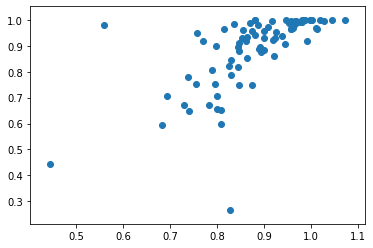

In [242]:
plt.scatter(model.predict(X_tr), y_tr)

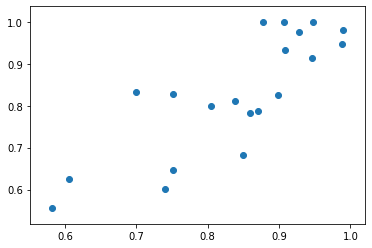

In [243]:
plt.scatter(model.predict(X_test), y_test)

0.3792476014835186

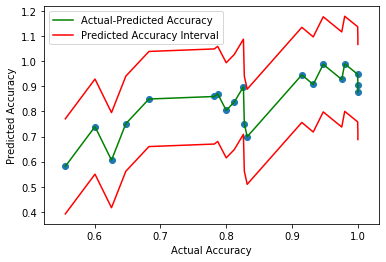

In [308]:
# make predictions
yhat = model.predict(X_tr)
# estimate stdev of yhat
sum_errs = arraysum((y_tr - yhat)**2)
stdev = sqrt(1/(len(y)-2) * sum_errs)
# calculate prediction interval
interval = 1.96 * stdev
y_hat = model.predict(X_test)
arg = y_test.argsort()
plt.scatter(y_test, y_hat)
plt.plot(y_test.values[arg], y_hat[arg], color='green', label='Actual-Predicted Accuracy')
plt.plot(y_test.values[arg], y_hat[arg] - interval, color='red', label='Predicted Accuracy Interval')
plt.plot(y_test.values[arg], y_hat[arg] + interval, color='red')
plt.xlabel('Actual Accuracy')
plt.ylabel('Predicted Accuracy')
plt.legend(loc="upper left")
plt.savefig('./bench_figs/tb_model.pdf', format='pdf')
interval * 2

0.3792476014835186

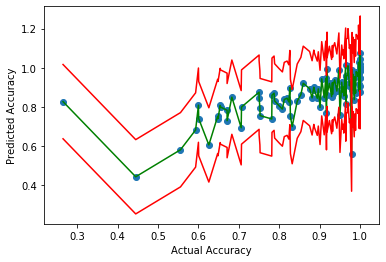

In [304]:
# make predictions
yhat = model.predict(X_tr)
# estimate stdev of yhat
sum_errs = arraysum((y_tr - yhat)**2)
stdev = sqrt(1/(len(y)-2) * sum_errs)
# calculate prediction interval
interval = 1.96 * stdev
y_hat = model.predict(X)
arg = y.argsort()
plt.scatter(y, y_hat)
plt.plot(y.values[arg], y_hat[arg], color='green')
plt.plot(y.values[arg], y_hat[arg] - interval, color='red')
plt.plot(y.values[arg], y_hat[arg] + interval, color='red')
plt.xlabel('Actual Accuracy')
plt.ylabel('Predicted Accuracy')
interval * 2

# GradientBoostingRegressor

In [247]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [248]:
# Fit models
lower_model.fit(X_tr, y_tr)
mid_model.fit(X_tr, y_tr)
upper_model.fit(X_tr, y_tr)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [251]:
predictions
for i in range(y_test.size):
    if predictions.iloc[i,0] < predictions.iloc[i,3] and predictions.iloc[i,0] > predictions.iloc[i,1]:
        print('Yes')
    else:
        print('No')

No
Yes
No
Yes
Yes
Yes
Yes
No
Yes
No
Yes
No
Yes
No
No
No
Yes
Yes
Yes
No


# Regression with normal distribution v.s Regression with T distribution

In [176]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc3
import arviz as az
from scipy import stats
import seaborn as sns
from statsmodels import api as sm

In [177]:
ols_result = sm.OLS(y_train.values, X_train.values).fit()
print('RMSE of OLS for test data: {:.4f}'.format(
        np.sqrt(mean_squared_error(y_test, ols_result.predict(X_test)))))

RMSE of OLS for test data: 0.0925


In [116]:
with pymc3.Model() as model:
    # Regression coefficients
    alpha = pymc3.Uniform('alpha', -100, 100)
    beta = pymc3.Uniform('beta', -100, 100)
    
    # Expected value
    y_hat = alpha + beta * X_train
    
    # Observations with t-distributed error
    y_obs = pymc3.T('y_obs', nu=5, mu=y_hat, observed=y)

AttributeError: module 'pymc3' has no attribute 'T'

In [120]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])

In [130]:
X = sm.add_constant(x)

In [131]:
ols_result = sm.OLS(y, X).fit()

In [133]:
x_no_outlier = x[x != 13]
X_no_outlier = X[x != 13]
y_no_outlier = y[x != 13]

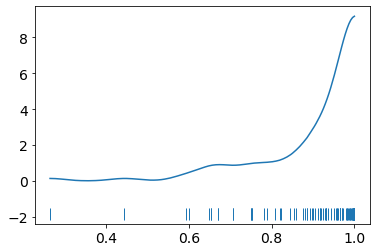

In [179]:
az.plot_kde(y_tr, rug=True)
#plt.yticks([0], alpha=0);

In [164]:
with pymc3.Model() as model_g:
    μ = pymc3.Uniform('μ', lower=0, upper=1)
    σ = pymc3.HalfNormal('σ', sd=0.5)
    y = pymc3.Normal('y', mu=μ, sd=σ, observed=y_tr)
    trace_g = pymc3.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 4000/4000 [02:00<00:00, 33.07draws/s]


C:\Users\HassanEldeeb\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\HassanEldeeb\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002386EB17908>,
      dtype=object)

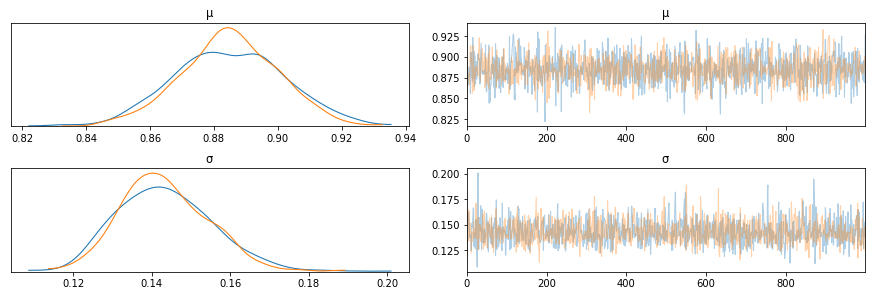

In [165]:
az.plot_trace(trace_g)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002386E078308>,
      dtype=object)

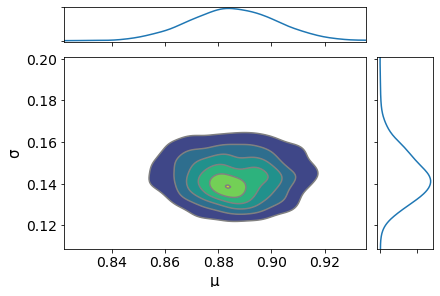

In [166]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [180]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,0.885,0.016,0.855,0.915,0.0,0.0,1733.0,1728.0,1730.0,1385.0,1.01
σ,0.144,0.012,0.124,0.166,0.0,0.0,1707.0,1666.0,1767.0,1256.0,1.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002386B9EBD08>,
      dtype=object)

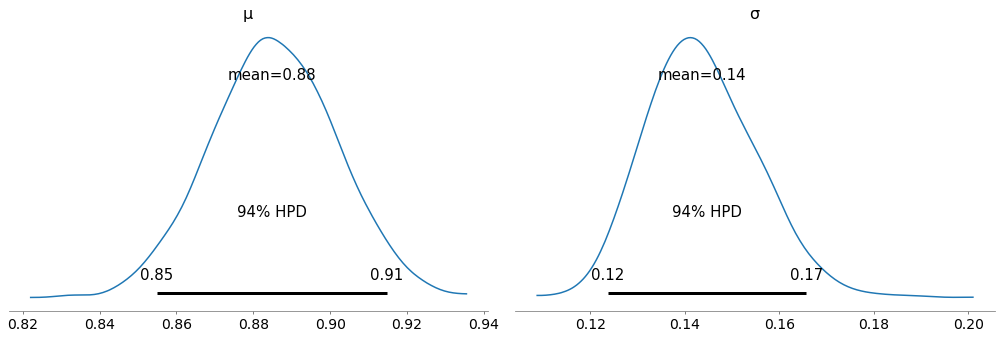

In [181]:
az.plot_posterior(trace_g)

In [182]:
pymc3.gelman_rubin(trace_g)

C:\Users\HassanEldeeb\Anaconda3\lib\site-packages\pymc3\stats\__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 1.01
    σ        float64 1.002

Text(0.5, 1.0, "BFMI = [1.02724153 1.26132289]\nGelman-Rubin = <xarray.DataArray 'μ' ()>\narray(1.00999901)")

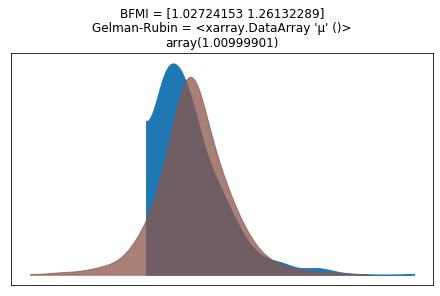

In [186]:
bfmi = pymc3.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pymc3.gelman_rubin(trace_g).values())
(pymc3.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)))

In [188]:
ppc = pymc3.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

C:\Users\HassanEldeeb\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 849.25it/s]


(1000, 79)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'mean(x)'),
 Text(0.5, 1.0, 'Posterior predictive of the mean')]

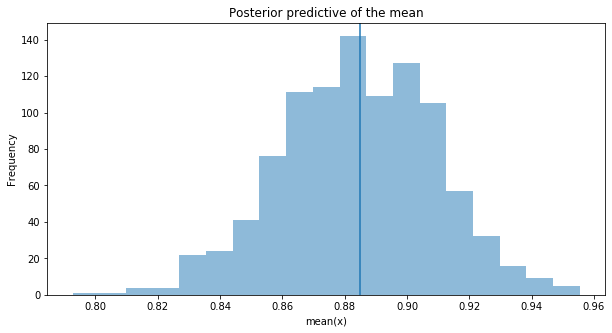

In [190]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(y_tr.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')

In [231]:
# linear regression prediction with prediction interval
from numpy.random import randn
from numpy.random import seed
from numpy import power
from numpy import sqrt
from numpy import mean
from numpy import std
from numpy import sum as arraysum
from scipy.stats import linregress
from matplotlib import pyplot
# seed random number generator
seed(1)
# fit linear regression model
model.fit(X_tr, y_tr)
# make predictions
yhat = model.predict(X_tr)
# estimate stdev of yhat
sum_errs = arraysum((y_tr - yhat)**2)
stdev = sqrt(1/(len(y)-2) * sum_errs)
# calculate prediction interval
interval = 1.96 * stdev

# define new input, expected value and prediction
for i in range(y_test.size):
    x_in = X_test.iloc[i,:].values.reshape(1, -1)
    y_out = y_test.iloc[i]
    yhat_out = model.predict(x_in)
    lower, upper = yhat_out - interval, yhat_out + interval
    if y_out < upper and y_out > lower:
        print('Yes')
    else:
        print('No')
#     print('Prediction Interval: %.3f' % interval)
#     print('Prediction Value: %.3f' % yhat_out)
#     print('95%% likelihood that the true value is between %.3f and %.3f' % (lower, upper))
#     print('True value: %.3f' % y_out)

No
Yes
No
Yes
Yes
No
Yes
Yes
Yes
No
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
Yes
No


In [225]:
y_test.iloc[2]

0.6257211930646812